In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

tf.config.set_visible_devices([], 'GPU')

## データ生成

カウントデータを生成する.

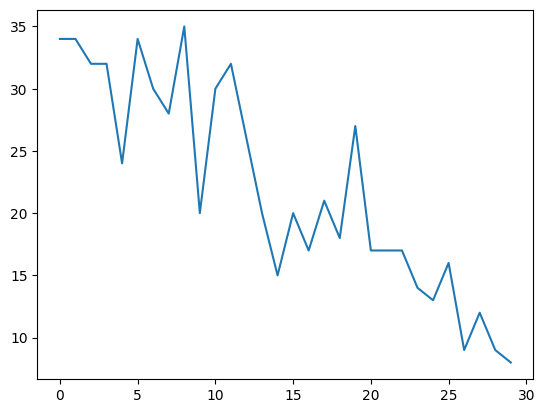

In [2]:
num_timesteps = 30
observed_counts = np.round(
    3 + np.random.lognormal(
        np.log(np.linspace(num_timesteps, 5, num=num_timesteps)),
        0.20,
        size=num_timesteps,
    )
)
observed_counts = observed_counts.astype(np.float32)
plt.plot(observed_counts)
plt.show()

## モデリング

In [3]:
def build_model(approximate_unconstrained_rates):
    trend = tfp.sts.LocalLinearTrend(
        observed_time_series=approximate_unconstrained_rates
    )
    return tfp.sts.Sum(
        [trend], observed_time_series=approximate_unconstrained_rates
    )

In [4]:
positive_bijector = tfb.Softplus()

approximate_unconstrained_rates = positive_bijector.inverse(
    tf.convert_to_tensor(observed_counts) + 0.01
)
sts_model = build_model(approximate_unconstrained_rates)

In [5]:
def sts_with_poisson_likelihood_model():
    param_vals = []
    for param in sts_model.parameters:
        param_val = yield param.prior
        param_vals.append(param_val)
        
    unconstrained_rate = yield sts_model.make_state_space_model(num_timesteps, param_vals)
    rate = positive_bijector.forward(unconstrained_rate[..., 0])
    observed_counts = yield tfd.Poisson(rate, name="observed_counts")
    
model = tfd.JointDistributionCoroutineAutoBatched(sts_with_poisson_likelihood_model)

In [6]:
pinned_model = model.experimental_pin(observed_counts=observed_counts)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2023-04-02 22:45:19.252046: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library


In [7]:
constraining_bijector = pinned_model.experimental_default_event_space_bijector()

2023-04-02 22:45:27.527456: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## HMC による推論

In [8]:
num_results = 500
num_results = int(num_results)

num_burnin_steps = 100
num_burnin_steps = int(num_burnin_steps)

In [9]:
sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=pinned_model.unnormalized_log_prob,
        step_size=.1,
    ),
    bijector=constraining_bijector,
)

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=0.75,
)

initial_state = constraining_bijector.forward(
    type(pinned_model.event_shape)(
        *(
            tf.random.normal(part_shape)
            for part_shape in constraining_bijector.inverse_event_shape(
                pinned_model.event_shape
            )
         )
    )
)

In [10]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
    return tfp.mcmc.sample_chain(
        kernel=adaptive_sampler,
        current_state=initial_state,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        trace_fn=None
    )

t0 = time.time()
samples = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

2023-04-02 22:45:37.205032: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x178d4d9d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-02 22:45:37.205046: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-04-02 22:45:37.276722: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-02 22:45:37.384038: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2023-04-02 22:45:40.538650: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Inference ran in 5.63s.


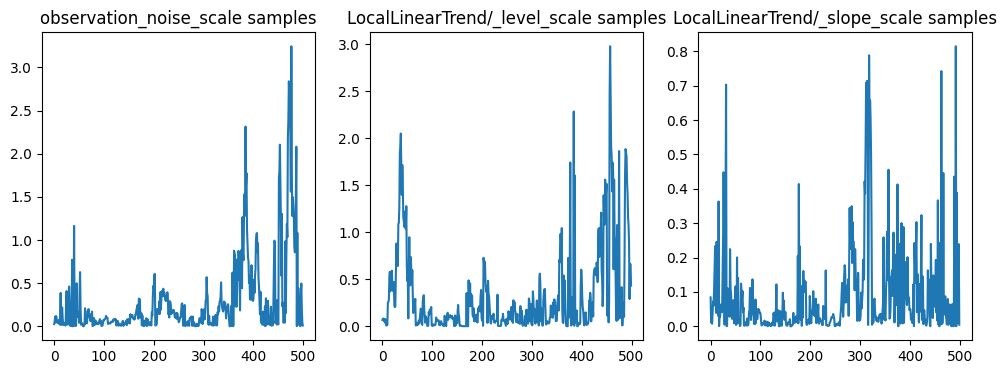

In [11]:
f = plt.figure(figsize=(12, 4))
for i, param in enumerate(sts_model.parameters):
    ax = f.add_subplot(1, len(sts_model.parameters), i + 1)
    ax.plot(samples[i])
    ax.set_title("{} samples".format(param.name))
plt.show()

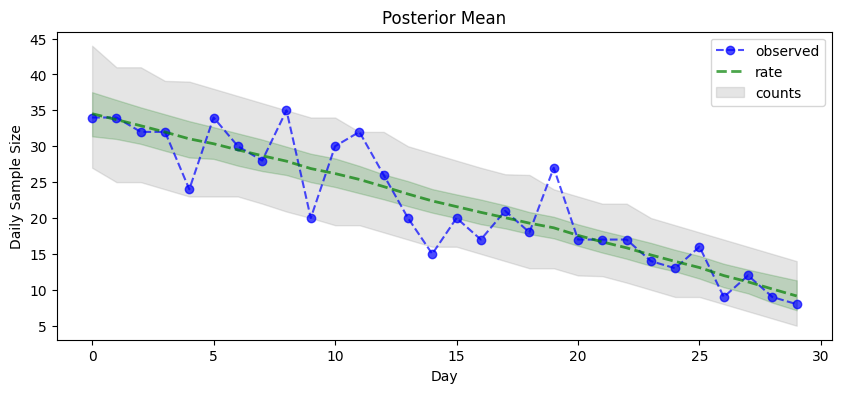

In [12]:
param_samples = samples[:-1]
unconstrained_rate_samples = samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)

plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), 
                                       [10, 90], axis=0)

_ = plt.plot(observed_counts, color="blue", ls='--', marker='o', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color="green", ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, 30), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, 30), pred_lower, pred_upper, color='grey', label='counts', alpha=0.2)
plt.xlabel("Day")
plt.ylabel("Daily Sample Size")
plt.title("Posterior Mean")
plt.legend()
plt.show()

In [13]:
def sample_forecasted_counts(
    sts_model, 
    posterior_latent_rates,
    posterior_params, 
    num_steps_forecast,
    num_sampled_forecasts,
):
    # Forecast the future latent unconstrained rates, given the inferred latent
    # unconstrained rates and parameters.
    unconstrained_rates_forecast_dist = tfp.sts.forecast(
        sts_model,
        observed_time_series=unconstrained_rate_samples,
        parameter_samples=posterior_params,
        num_steps_forecast=num_steps_forecast
    )
    
    # Transform the forecast to positive-valued Poisson rates.
    rates_forecast_dist = tfd.TransformedDistribution(
        unconstrained_rates_forecast_dist, positive_bijector
    )
    
    # Sample from the forecast model following the chain rule:
    #  P(counts) = P(counts | latent_rates)P(latent_rates)
    sampled_latent_rates = rates_forecast_dist.sample(num_sampled_forecasts)
    sampled_forecast_counts = tfd.Poisson(rate=sampled_latent_rates).sample()

    return sampled_forecast_counts, sampled_latent_rates

forecast_samples, rate_samples = sample_forecasted_counts(
    sts_model,
    posterior_latent_rates=unconstrained_rate_samples,
    posterior_params=param_samples,
    # Days to forecast:
    num_steps_forecast=30,
    num_sampled_forecasts=100
)

In [14]:
forecast_samples = np.squeeze(forecast_samples)

In [15]:
def plot_forecast_helper(data, forecast_samples, CI=90):
    """Plot the observed time series alongside the forecast."""
    plt.figure(figsize=(10, 4))
    forecast_median = np.median(forecast_samples, axis=0)
    
    num_steps = len(data)
    num_steps_forecast = forecast_median.shape[-1]
    
    plt.plot(
        np.arange(num_steps),
        data,
        lw=2,
        color='blue',
        linestyle='--',
        marker='o',
        label='Observed Data',
        alpha=0.7,
    )
    
    forecast_steps = np.arange(num_steps, num_steps + num_steps_forecast)
    
    CI_interval = [(100 - CI)/2, 100 - (100 - CI)/2]
    lower, upper = np.percentile(forecast_samples, CI_interval, axis=0)
    
    plt.plot(
        forecast_steps,
        forecast_median,
        lw=2,
        ls='--',
        marker='o',
        color='orange',
        label=str(CI) + '% Forecast Interval',
        alpha=0.7,
    )
    plt.fill_between(forecast_steps, lower, upper, color='orange', alpha=0.2)
    
    plt.xlim([0, num_steps + num_steps_forecast])
    ymin, ymax = min(np.min(forecast_samples), np.min(data)), max(np.max(forecast_samples), np.max(data))
    yrange = ymax-ymin
    plt.title("{}".format('Observed time series with ' + str(num_steps_forecast) + ' Day Forecast'))
    plt.xlabel('Day')
    plt.ylabel('Daily Sample Size')
    plt.legend()

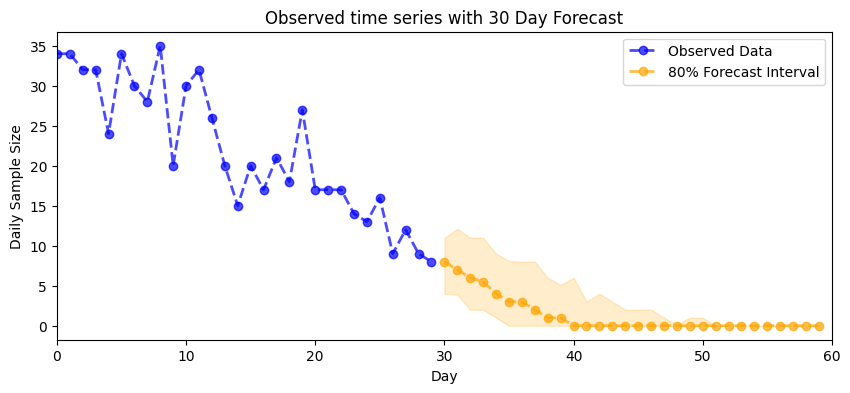

In [16]:
plot_forecast_helper(observed_counts, forecast_samples, CI=80)
plt.show()

## 変分推論

In [17]:
surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
    event_shape=pinned_model.event_shape,
    bijector=constraining_bijector,
)

In [18]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 1000 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

t0 = time.time()
losses = tfp.vi.fit_surrogate_posterior(
    pinned_model.unnormalized_log_prob,
    surrogate_posterior,
    optimizer=tf.optimizers.Adam(0.1),
    num_steps=num_variational_steps,
)
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 7.57s.


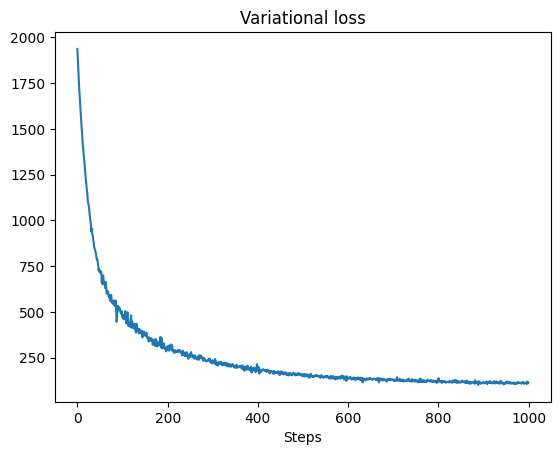

In [19]:
plt.plot(losses)
plt.title("Variational loss")
_ = plt.xlabel("Steps")

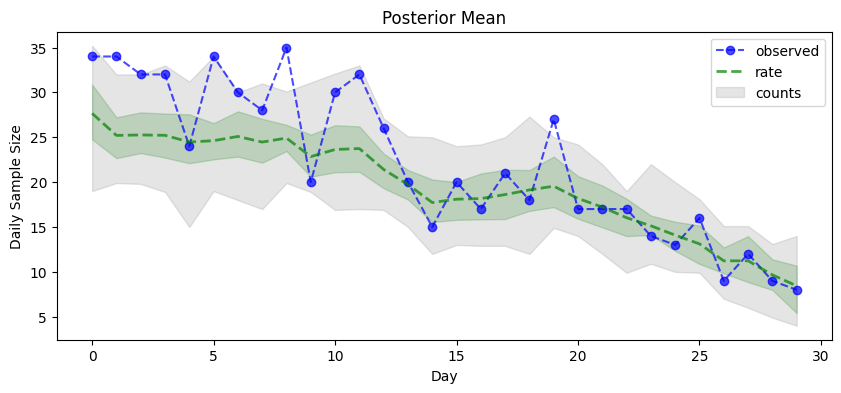

In [20]:
posterior_samples = surrogate_posterior.sample(50)
param_samples = posterior_samples[:-1]
unconstrained_rate_samples = posterior_samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)

plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), [10, 90], axis=0)

_ = plt.plot(observed_counts, color='blue', ls='--', marker='o', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color='green', ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, 30), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, 30), pred_lower, pred_upper, color='grey', label='counts', alpha=0.2)
plt.xlabel('Day')
plt.ylabel('Daily Sample Size')
plt.title('Posterior Mean')
plt.legend()
plt.show()

In [21]:
forecast_samples, rate_samples = sample_forecasted_counts(
    sts_model,
    posterior_latent_rates=unconstrained_rate_samples,
    posterior_params=param_samples,
    # Days to forecast:
    num_steps_forecast=30,
    num_sampled_forecasts=100
)

In [22]:
forecast_samples = np.squeeze(forecast_samples)

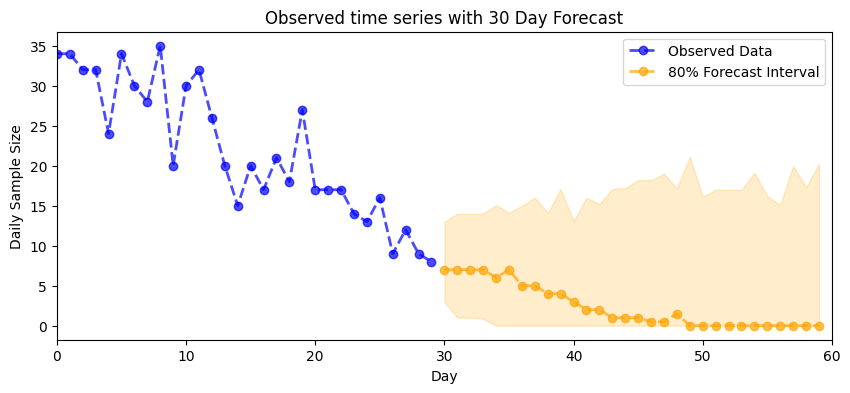

In [23]:
plot_forecast_helper(observed_counts, forecast_samples, CI=80)